# Section 2.3.3: Kaplan-Meier and Nelson-Aalen Estimators

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to use the Kaplan-Meier estimator (Kaplan and Meier, 1958) and the Nelson-Aalen estimator (Nelson, 1969; Aalen, 1978) from the `lifelines` package, with an optional time discretization step that is done using PyCox code. For an overview of these two estimators, please see Example 2.3.3 in Section 2.3.3 of the monograph. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail.

In the monograph, we derived Kaplan-Meier and Nelson-Aalen estimators as maximum likelihood estimators and, in fact, they can trivially be computed in closed form. For this reason, this demo is not going to use any PyTorch functionality. Note that this demo mostly focuses on the Kaplan-Meier estimator, which estimates a population-level survival function from training data. We briefly also show how to fit a Nelson-Aalen estimator of the population-level cumulative hazard function.

Note that the Kaplan-Meier and Nelson-Aalen estimators are population-level estimators that don't need input feature vectors and also don't have hyperparameters to tune. Thus, we will *not* split the data into training/validation/test sets. Instead, we just use a train/test split (the same first split that happens in the exponential time-to-event prediction model demo). In other words, what we called the "full training data" is the same as the "training data" for this specific demo.

**Very important:** We can treat the Kaplan-Meier estimator's survival function (fitted to the full training data) as what we would predict as the survival function for every single test point. Using this idea, we can compute nearly all of the evaluation metrics (on *test* data) that we presented in Section 2.4 of the monograph. This idea is useful because for some evaluation metrics (such as the integrated Brier score), it might not be obvious what a "baseline" score should be. The Kaplan-Meier estimator can thus be used to obtain a trivial baseline score.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

The data loading is much simpler now.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# the suffix "_np" indicates a numpy array
# (we convert arrays/tables between NumPy array, Pandas DataFrame, and PyTorch tensor formats)
_, Y_train_np, D_train_np, _, Y_test_np, D_test_np, _, _, _, _, _, _ = load_dataset('support')

print(f'Training set size {Y_train_np.shape[0]}')
print(f'Test set size {Y_test_np.shape[0]}')

Training set size 6211
Test set size 2662


### Discretizing time

Here, we just point out that if for whatever reason, the modeler would like to discretize time prior to fitting the Kaplan-Meier estimator, then this is indeed possible. By default, in the code cell below, we actually set the time steps to be the unique times of death in the dataset (but this can easily be changed by modifying the `num_time_steps` variable).

If time discretization is used (when `num_time_steps` is set to be larger than 0), then we use PyCox's provided `LabTransDiscreteTime` class that helps discretize time. Note that there are many ways to discretize time (see Section 2.3.2 of the monograph).

In [2]:
import numpy as np

num_time_steps = 0  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    Y_train_binned_np = Y_train_np
    D_train_discrete_np = D_train_np

    mask = (D_train_np == 1)  # boolean mask specifying which training points experienced death
    time_grid_train_np = np.unique(Y_train_np[mask])
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed time values)
    from pycox.preprocessing.label_transforms import LabTransDiscreteTime
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

    Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
    # note: PyCox's discretization code allows for the possibility that the event indicator changes
    # (if a patient's survival time is known so that the event indicator is 1, but the survival time
    # is after the maximum discrete time grid time, then the patient's event indicator is changed to
    # being censored)

    time_grid_train_np = label_transform.cuts

    # note that `Y_train_discrete_np` gives the new discretized times in terms of *integer indices*
    # and not actual times; we convert these integer indices into actual discretized times:
    Y_train_binned_np = np.array([time_grid_train_np[index] for index in Y_train_discrete_np])

output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with the Kaplan-Meier estimator: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with the Kaplan-Meier estimator: 883
Time grid: [   3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.
   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.
   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.
   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.   74.
   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.
   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.
   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.
  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.
  123.  124.  125.  126.  127.  128.  129.  130.  132.  133.  134.  135.
  136.  137.  138.  139.  140.  141.  142.  143.  144.  145.  146.  147.
  148.  149.  150.  151.  152.  153.  154.  

### Fitting the Kaplan-Meier estimator

<Axes: xlabel='timeline'>

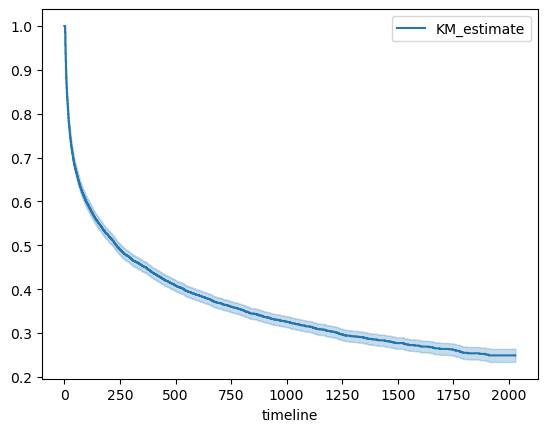

In [3]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(Y_train_binned_np, D_train_discrete_np)
kmf.plot()

In [4]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
3.0,0.985832
4.0,0.956851
5.0,0.936242
6.0,0.919176
...,...
2024.0,0.248896
2026.0,0.248896
2027.0,0.248896


Note that by default, time 0 gets added even if it did not show up as one of the training set's observed times of death.

We store the time grid and survival function in separate NumPy tables as we will use these later.

In [5]:
time_grid_KM_np = kmf.survival_function_.index.to_numpy()
surv_KM_np = kmf.survival_function_.to_numpy().flatten()

We could also essentially manually plot the Kaplan-Meier curve ourselves (although this doesn't plot pointwise confidence intervals).

Text(0, 0.5, 'Survival probability')

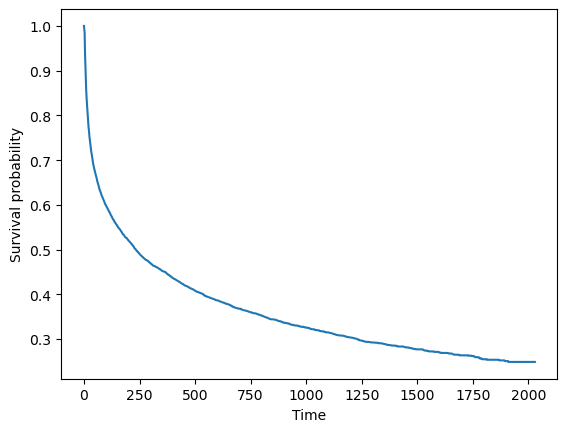

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_grid_KM_np, surv_KM_np)
plt.xlabel('Time')
plt.ylabel('Survival probability')

In [7]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(Y_train_binned_np, D_train_discrete_np)

time_grid_NA_np = naf.cumulative_hazard_.index.to_numpy()
cumulative_hazard_NA_np = naf.cumulative_hazard_.to_numpy().flatten()

Text(0, 0.5, 'Cumulative hazard')

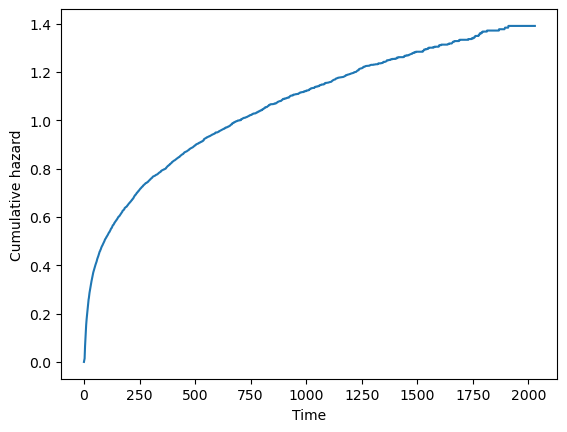

In [8]:
plt.plot(time_grid_NA_np, cumulative_hazard_NA_np)
plt.xlabel('Time')
plt.ylabel('Cumulative hazard')

### Predicting test set survival curves

We treat the Kaplan-Meier estimator's survival function (fitted to the training data) as what we would predict to be every single test point's survival function.

In [9]:
surv_test_np = np.tile(surv_KM_np, (Y_test_np.shape[0], 1))

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [10]:
time_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [11]:
import pandas as pd
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_KM_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.0


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [12]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the Kaplan-Meier time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_KM_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5
Eval time 693.0 - truncated time-dependent concordance: 0.5
Eval time 1291.0 - truncated time-dependent concordance: 0.5


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [13]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the Kaplan-Meier time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_KM_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.5
Eval time 693.0 - time-dependent AUC: 0.5
Eval time 1291.0 - time-dependent AUC: 0.5


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [14]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_KM_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.24812668066770502
Eval time 693.0 - Brier score: 0.22996634828274495
Eval time 1291.0 - Brier score: 0.20388111570630055
Integrated Brier score: 0.20744689372386935


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [15]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [16]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 625.8539578196724


In [17]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 744.0844621826878
